# 7CCSMQMF Python Coding Coursework
> Author: K23110833 CHIA-HUNG, YANG


**Instructions**: This is a coursework on the use of the Monte Carlo scheme to price Asian options, to be
completed using a Jupyter Notebook. It will test your understanding of the lecture on Monte Carlo and
Exotics. You may use the code given in 7CCSMSCF to simulate the underlying stock.
## Task
Use the expected value of the discounted payo§ under the risk-neutral density Q 
V (S; t) = e ^ r(T-t) EQ[Payoff(ST )]
for the appropriate form of payoff, to consider
- Asian (fixed and foating strike) options.
- Super share options - you will need to research these options and their payoff.
Use the Euler-Maruyama scheme for initially simulating the underlying stock price. As an initial example
you may use the following set of sample data

- Today's stock price $S_0$ = 100
- Strike E = 100
- Time to expiry (T - t) = 1 year
- volatility $\sigma$ = 20%
- constant risk-free interest rate $r$ = 5%

Then vary the data to see the affect on the option price

---

## Index
1. Introduction
    - Monte Carlo simulation
    - Asian options
    - Supershare options
2. Building functions
3. Simulating results and observations
4. Problem discussion
5. Conclution and reference

---

## 1. Introduction
### Monte Carlo simultation [1]
The fair value of an option is the present value of the expected payoff at expiry under a **risk-neutral** random walk for the underlying.

A risk-neutral random walk can be noted as :

$dS \over S$ = $rdt$ + $\sigma dX^Q$

This is simply the GBM(Geometric Brownian motion ) with risk free rate $r$ instead of the real growth rate $\mu$
Where:
- `S` is the stock price (the variable that follows a lognormal distribution)
- `r` is the risk-neutral growth rate/drift
- `σ` is the volatility of the stock price returns
- `dt` is a small step in time

Therefore, we can rewrite the option value as:

$option \ value$ = $e^{-r(T-t)}E^Q$[payoff(S)]

where we use the monte carlo method to simulate the payoff(S)

To apply the Monte Carlo method to option pricing, you simulate a large number of paths for the underlying asset price, apply the payoff function of the option to these simulated end prices to get a distribution of payoffs, and then average them to get an expected payoff. To discount this to present value, you would typically use the risk-free rate.

The pseudo-code using the Monte Carlo method to price an option might look something like this:

1. Define the parameters of the option: $S_0$ (initial stock price), $K$ (strike price), $T$ (time to expiration), $r$ (risk-free rate), $\sigma$ (volatility), $n$ (number of simulations).

2. For i = 1 to $n$:

    a. Simulate a path for the underlying asset price over the time to expiration.

    $S_{i+1}$ = $S_i$ + $\sigma S_i \sqrt {dt} \phi$ + $rS_idt$

    b. Calculate the payoff from the option for this path.
   
3. Average all the payoffs to get an expected payoff.

    $1 \over n$ $\sum_{i=1}^{n} max(S_T^i - E, 0)$

4. Discount the expected payoff at the risk-free rate to get the present value (PV) of the option.

    $pv = e^{-r(T)}$

5. Option Price = $pv*Payoff(S)$


### Asian options [2][3]
Asian options are exotic options whose payoff depends on the average price of the underlying asset over a certain period rather than just the price of the underlying asset at maturity. This feature makes them less susceptible to market manipulation and reduces the volatility of the option's price. There are two main types of Asian options: fixed Asian options (also known as average price options) and floating Asian options (also known as average strike options). 

#### Fixed Asian Options (Average Price Options)
A fixed Asian option has a predetermined strike price, and its payoff is determined by comparing this strike price with the average price of the underlying asset.

#### Call
For an Asian fixed call option, the payoff at expiration is calculated as follows:

```
Payoff = max(Average Price - Strike Price, 0)
```

This means that if the average price of the underlying asset over the specified period is higher than the strike price, the owner of the call option will make a profit equal to the difference. If the average price is less than or equal to the strike price, the option expires worthless.

#### Put
For an Asian fixed put option, the payoff at expiration is calculated as:

```
Payoff = max(Strike Price - Average Price, 0)
```

The put option will be profitable if the average price of the underlying asset is below the strike price.

The average price can be calculated in various ways, such as arithmetic or geometric means, and the averaging period can be set according to the specific terms of the option, like daily, weekly, or monthly averaging.

#### Floating Asian Options (Average Strike Options)
A floating Asian option has a strike price that is determined by the average price of the underlying asset over a certain period.

#### Call
For an Asian floating call option, the payoff is computed as:

```
Payoff = max(Final Price - Average Price, 0)
```

With this option, the holder has the right to buy the underlying asset at its average price. They profit if the final price of the underlying asset is above the average price during the averaging period.

#### Put
Similarly, for an Asian floating put option, the payoff is:

```
Payoff = max(Average Price - Final Price, 0)
```

The holder of a floating put option has the right to sell the underlying asset at its average price. The option is valuable if the final price of the underlying asset is below the average price.

### Supershare options [4]
In the book The complete guide to option pricing formulas (Second edition.). Haug, E. G. (2007) page 176 found the following:

A super share option, originally introduced introduced by Hakansson(1976), entitles it's holder to a payoff of $S/X_L$ if $X_L <= S < X_H$ and 0 otherwise.

$w = (Se^{(b-r)T}/X_L)[N(d1) - N(d2)]$

where 

$d1 = {{ln(S/X_L) + (b + \sigma^2/2)T} \over {\sigma \sqrt{T}}}$

$d2 = {{ln(S/X_H) + (b + \sigma^2/2)T} \over {\sigma \sqrt{T}}}$

**Application**
A profolio of supershare options can be used to construct what is known as a superfund -- traded at the American Stock Exchange under the name SuperUnits and at the Chicago Board Options Exchange as SuperShares

---

## 2. Building Functions
First, let's import some necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Random walk function
First, we build a function called `random_walk` by the method told on the lecture `Scientific Computing for Finance` by Dr Bart

I made some modifications and make it more adaptable on this coursework.

The function takes serval inputs:
- vars: a tuple contains stock_price, r, sigma, dt, days
- simulations: an integer for the times of random walk simulation is performed
- plot: if the function plot a diagram of random walk
- mean method: the method to calculate price average throughout the simulation path (This is for Asian option)

The function will output two element:
- The last price value PO (array shape: (simulations, 1))
- The average of the prices throughout the simulation path (arithmetic or geometric)

In [2]:
def random_walk(vars, simulations, plot=False, mean_method='arithmetic'):
    '''
    A Function to do n times random walk simultions
    Input:
    vars: tuple (stock_price, r, sigma, dt, days)
    simulations: int for the times of random walk simulation is performed
    plot: bool if the function plot a diagram of random walk
    mean method: str the method to calculate price average throughout the simulation path (This is for Asian option)

    Output:
    The last price value PO (array shape: (simulations, 1))
    The average of the prices throughout the simulation path (arithmetic or geometric)
    '''
    stock_price, r, sigma, dt, steps = vars     # unpack the tuple
    initial_value = stock_price                 # set initial stock price
    random_numbers = np.random.normal(size=(steps,simulations)) # generate random numbers as a matrix
    price_function = 1 + random_numbers* sigma * np.sqrt(dt) + r*dt # Si+1/Si
    values = initial_value * np.cumprod(price_function,axis=0)      #cumulative product to simulate the path
    # if we need to plot the random walk 
    if plot:
        plt.xlabel('$t$')
        plt.ylabel('$y_t$')
        ax = plt.plot(np.concatenate((np.matrix(np.full((simulations),[initial_value])), values),axis=0))
    # select the output method for the average price
    try:
        assert mean_method == 'arithmetic'
        return values[-1], np.mean(values, axis=0)
    except:
        a = np.log(values)
        gmean = np.exp(a.mean(axis=0))
        return values[-1],gmean

Check if the function really works
- Today's stock price S0 = 100
- volatility sigma = 20%
- constant risk-free interest rate r =5%
- Time to expiry (T- t) = 1 year

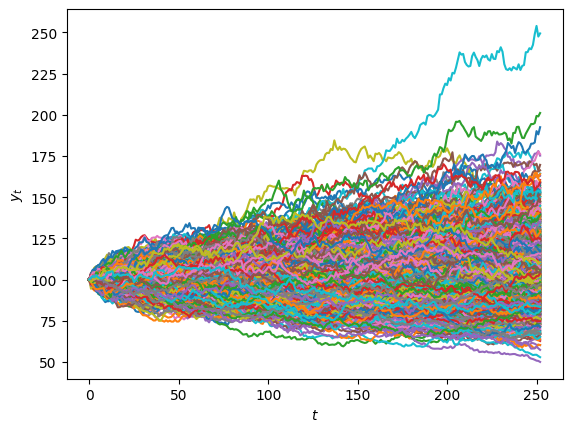

In [3]:
stock_price = 100.0
r = 0.05
sigma = 0.2
dt = 1/252
n = 252
variables = (stock_price, r, sigma, dt, n)
simulations = 1000
PO_price, average = random_walk(variables, simulations, plot=True)

Show 5 results to compare arithmetic average with geometric average

In [4]:
PO_price, geo_average = random_walk(variables, simulations, mean_method='geo')
print('arithmetic average: ', average[0:5])
print('geometric average:  ', geo_average[0:5])

arithmetic average:  [ 81.94522624 104.68246829  92.21556878 112.68160347  92.40181246]
geometric average:   [108.38400655  86.97302543  93.80027416  89.50576612 103.78584827]


### Asian Fixed Strike Call Option
Then we build the function `AsianFixCall` for simulating the Asian Fixed Strike Call Option 
- PO = PV * Max(Average - Strike, 0)

In [5]:
def AsianFixCall(pv, average, Strike_price):
    PO = pv * np.where((average - Strike_price)<= 0, 0, (average-Strike_price))
    return np.mean(PO)

We test the function with the previous random walk result.
- Strike E = 100
- Time = 1 year
- $pv = e^{-r(T)}$

In [54]:

stock_price = 100.0
r = 0.05
sigma = 0.2
dt = 1/252
n = 252
variables = (stock_price, r, sigma, dt, n)
simulations = 500000
Time = 1
Strike_price = 100
pv = np.exp(-r*Time)
PO_price, average = random_walk(variables, simulations)
AsianFixCall(pv, average, Strike_price)

5.786189933569584

### Asian Fixed Strike Put Option
we build the function `AsianFixPut` for simulating the Asian Fixed Strike Put Option 
- PO = PV * Max(Strike - A, 0)

In [7]:
def AsianFixPut(pv, average, Strike_price):
    PO = pv * np.where((Strike_price - average) <= 0, 0, (Strike_price - average))
    return np.mean(PO)

test the put function

In [55]:
AsianFixPut(pv,average,Strike_price)

3.3580113574439694

### Asian Floating Strike Call Option
we build the function `AsianFloatCall` for simulating the Asian Floating Strike Call Option
- PO = PV * Max(S(t) - A, 0)

In [9]:
def AsianFloatCall(pv, average, PO_price):
    PO = pv * np.where((PO_price - average) <= 0, 0, (PO_price - average))
    return np.mean(PO)

test the function

In [56]:
AsianFloatCall(pv, average, PO_price)

5.86485555733023

### Asian Floating Strike Put Option
we build the function `AsianFloatPut` for simulating the Asian Floating Strike Put Option
- PO = PV * Max(A - S(t), 0)

In [11]:
def AsianFloatPut(pv, average, PO_price):
    PO = pv * np.where((average - PO_price) <= 0, 0, (average - PO_price))
    return np.mean(PO)

test the function

In [57]:
AsianFloatPut(pv, average, PO_price)  

3.390163371966297

### Try different sample number Results
We build a function to observe if the number of simulation effects the result
The function takes 4 inputs:
- sample_num: int ; the number of simulation
- option: str; the option type to simulate
- step: int; the step size
- plot: bool; if True, plot the graph

In [13]:
def compare_sample_number(sample_num, option, step=1, plot=False):
    sample_array = []
    for i in range(0, sample_num, step):
        if i == 0:
            continue
        p_price, average = random_walk(variables, i)
        if option == AsianFloatCall or AsianFloatPut:
            PO = option(pv, average, p_price)
        else:
            PO = option(pv, average, Strike_price)
        sample_array.append(PO)
    if plot:
        plt.plot(np.arange(0+step, sample_num, step),sample_array)
    return PO, sample_array

We try the 1 to 100,000 simulations on Asian Float Call function to see the results.

plot the result out to observe it

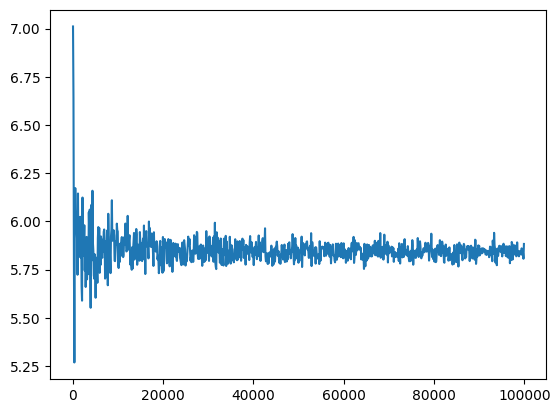

In [14]:
sample_num = 100000
PO, sample = compare_sample_number(sample_num, AsianFloatCall, step=100, plot=True)

We can't really know the standard normal on the graph, so we plot the 2 times standard normal band on the plot to enhence the observtion

Text(0, 0.5, 'Payoff')

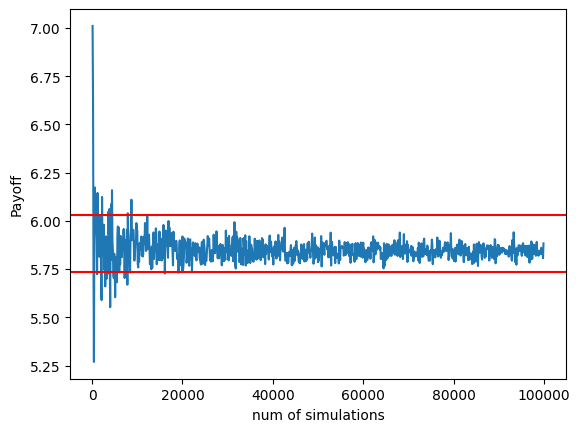

In [26]:
step = 100
plt.plot(np.arange(0+step, sample_num, step),sample)
plt.axhline(PO-2*np.std(sample),color='red')
plt.axhline(PO+2*np.std(sample),color='red')
plt.xlabel('num of simulations')
plt.ylabel('Payoff')

because the results from 50,000 to 100,000 doesn't show significant difference, I choose 50,000 for the rest of the simulations

### Supershare option
payout = $S/X_L$ 

if $X_L <= S < X_H$ 

In [18]:
def SupershareOption(pv, p_price, X_L, X_H):
    p_price = np.where(p_price<X_L, 0, p_price)
    PO = pv * np.where(p_price>=X_H, 0, p_price/X_L)
    return np.mean(PO)

Test the result by the parameteres given by Haug, E. G. (2007)
- S = 100
- $X_L$ = 90
- $X_H$ = 110
- T = 0.25
- r = 0.1
- b = 0
- $\sigma$ = 0.2

In [20]:
sso_S = 100
sso_X_L = 90
sso_X_H = 110
sso_T = 0.25
sso_r = 0.1
sso_b = 0
sso_sigma = 0.2
sso_n = 63
sso_dt = sso_T/sso_n

sso_variables = (sso_S, sso_r, sso_sigma, sso_dt, sso_n)
simulations = 50000
sso_p_price, sso_average = random_walk(sso_variables, simulations)
sso_pv = np.exp(-sso_r*sso_T)
sso_result = SupershareOption(sso_pv, sso_p_price, sso_X_L, sso_X_H)
print('SupershareOption price: ', sso_result)

SupershareOption price:  0.7242025247135307


Compare the result with the direvative solution:
$w = (Se^{(b-r)T}/X_L)[N(d1) - N(d2)]$

where 

$d1 = {{ln(S/X_L) + (b + \sigma^2/2)T} \over {\sigma \sqrt{T}}}$

$d2 = {{ln(S/X_H) + (b + \sigma^2/2)T} \over {\sigma \sqrt{T}}}$

In [23]:
b = 0
d1 = (np.log(sso_S/sso_X_L) + (b + (pow(sso_sigma,2))/2) * sso_T )/ (sso_sigma * np.sqrt(sso_T))
d2 = (np.log(sso_S/sso_X_H) + (b + (pow(sso_sigma,2))/2) * sso_T )/ (sso_sigma * np.sqrt(sso_T))
w = (sso_S*np.exp((b-sso_r) * sso_T)/sso_X_L) * (norm.cdf(d1) - norm.cdf(d2))
print('SupershareOption price by derivative: ', w)
print('SupershareOption price by simulation: ', sso_result)
print('errors: ', 100*abs(w-sso_result)/w, '%')

SupershareOption price by derivative:  0.7389401287052355
SupershareOption price by simulation:  0.7242025247135307
errors:  1.9944246386412745 %


The simulation results are close enough to the derivative values.

---

## 3. Simulation results and discussions
## 3.a First, we will discuss the results of different parameters on Asian options.

### Different Times to expiry
Compare different Time to expiry:
- We will test T from 1 year to 30 year

In [24]:
T = np.arange(1,30)
simulations = 50000
stock_price = 100.0
r = 0.05
sigma = 0.2

def compare_T(T):
    AsianFloatCall_T = []
    AsianFloatPut_T  = []
    AsianFixPut_T    = []
    AsianFixCall_T   = []
    for t in T:
        days = t * 252
        dt = 1/days
        variables = (stock_price, r, sigma, dt, days)
        p_price, average = random_walk(variables, simulations)
        pv = np.exp(-r*t)
        AsianFloatCall_T.append(AsianFloatCall(pv, average, p_price))
        AsianFloatPut_T.append(AsianFloatPut(pv, average, p_price))
        AsianFixPut_T.append(AsianFixPut(pv, average, Strike_price))
        AsianFixCall_T.append(AsianFixCall(pv, average, Strike_price))
        
    return AsianFloatCall_T, AsianFloatPut_T, AsianFixPut_T, AsianFixCall_T 

AsianFloatCall_T, AsianFloatPut_T, AsianFixPut_T, AsianFixCall_T  = compare_T(T)

Plot the figures to check the results

Text(0, 0.5, 'Payoff')

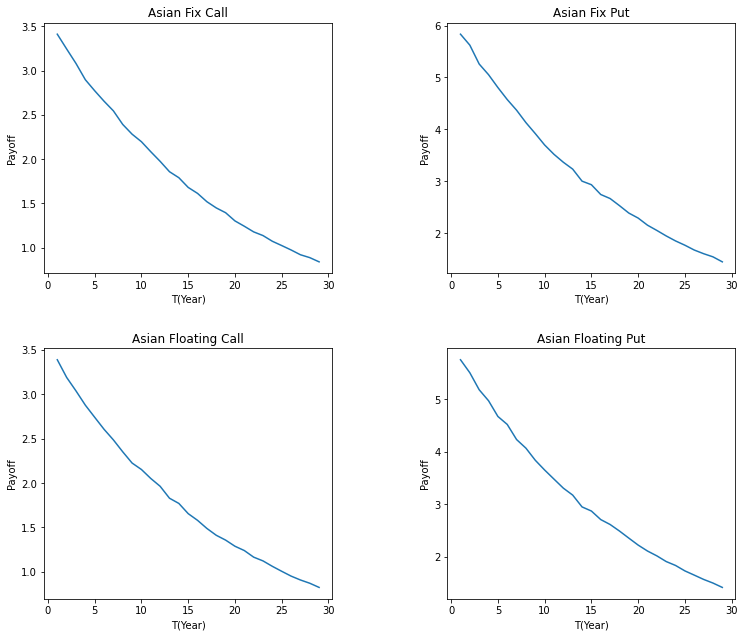

In [27]:
plt.figure(figsize=(12, 10), dpi=72 )
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
plt.subplot(221)
plt.plot(T, AsianFixCall_T)
plt.title('Asian Fix Call')
plt.xlabel('T(Year)')
plt.ylabel('Payoff')
plt.subplot(222)
plt.plot(T, AsianFixPut_T)
plt.title('Asian Fix Put')
plt.xlabel('T(Year)')
plt.ylabel('Payoff')
plt.subplot(223)
plt.plot(T, AsianFloatCall_T)
plt.title('Asian Floating Call')
plt.xlabel('T(Year)')
plt.ylabel('Payoff')
plt.subplot(224)
plt.plot(T, AsianFloatPut_T)
plt.title('Asian Floating Put')
plt.xlabel('T(Year)')
plt.ylabel('Payoff')

### Discussion for Different Times to expiry:
We can see that no matter put/call or Fixed/Float option has lower expected Payoff as time expands, and the price decays as a log decay.

The main reason might results to the pv.

$pv = e^{-rT}$ , the larger the T is, the smaller pv is.

Also, the longer days in the random walk simulation, the more unpredictable the prices will be.

---

### Different volatility($\sigma$)
Compare different volatility:
- $\sigma$ from 0.05 to 0.95 with step 0.05

In [28]:
simulations = 50000
stock_price = 100.0
r = 0.05
sigma = np.arange(0.05,0.95,0.05)
dt = 1/252
n = 252
T=1
pv = np.exp(-r*T)

def compare_sigma(sigma):
    AsianFloatCall_s = []
    AsianFloatPut_s  = []
    AsianFixPut_s    = []
    AsianFixCall_s   = []
    for s in sigma:
        variables = (stock_price, r, s, dt, n)
        p_price, average = random_walk(variables, simulations)
        AsianFloatCall_s.append(AsianFloatCall(pv, average, p_price))
        AsianFloatPut_s.append(AsianFloatPut(pv, average, p_price))
        AsianFixPut_s.append(AsianFixPut(pv, average, Strike_price))
        AsianFixCall_s.append(AsianFixCall(pv, average, Strike_price))
        
    return AsianFloatCall_s, AsianFloatPut_s, AsianFixPut_s, AsianFixCall_s 

AsianFloatCall_s, AsianFloatPut_s, AsianFixPut_s, AsianFixCall_s  = compare_sigma(sigma)


Text(0, 0.5, 'Payoff')

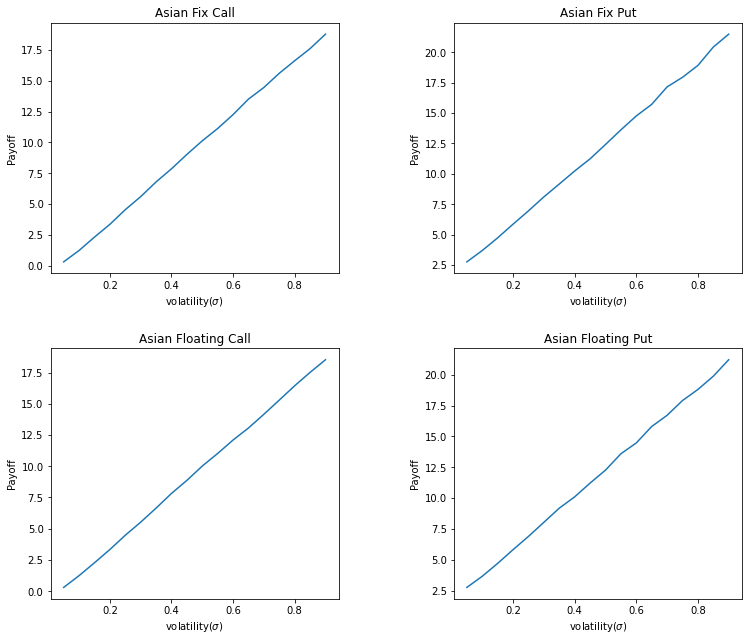

In [30]:
plt.figure(figsize=(12, 10), dpi=72)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
plt.subplot(221)
plt.plot(sigma, AsianFixCall_s)
plt.title('Asian Fix Call')
plt.xlabel('volatility($\sigma$)')
plt.ylabel('Payoff')
plt.subplot(222)
plt.plot(sigma, AsianFixPut_s)
plt.title('Asian Fix Put')
plt.xlabel('volatility($\sigma$)')
plt.ylabel('Payoff')
plt.subplot(223)
plt.plot(sigma, AsianFloatCall_s)
plt.title('Asian Floating Call')
plt.xlabel('volatility($\sigma$)')
plt.ylabel('Payoff')
plt.subplot(224)
plt.plot(sigma, AsianFloatPut_s)
plt.title('Asian Floating Put')
plt.xlabel('volatility($\sigma$)')
plt.ylabel('Payoff')

### Discussion of Different Volitility ($\sigma$)

The higher the $\sigma$ is, all the Asian options' prices goes higher.

This might result in the payoff formula, the higher the $\sigma$ is, the higher the final price might go (or lower on put options). This results in a linear better payoff causes the expected option price grows linearly.

---

### Different risk-free interest rate r
Compare different risk-free interest rate r:
- r from 0.005 to 0.1 withstep 0.005

In [31]:
simulations = 50000
stock_price = 100.0
IR = np.arange(0.005, 0.1, 0.005)
sigma = 0.2
dt = 1/252
n = 252 
T = 1

def compare_sigma(IR):
    AsianFloatCall_r = []
    AsianFloatPut_r  = []
    AsianFixPut_r    = []
    AsianFixCall_r   = []
    for rate in IR:
        variables = (stock_price, rate, sigma, dt, n)
        p_price, average = random_walk(variables, simulations)
        pv = np.exp(-rate*T)
        AsianFloatCall_r.append(AsianFloatCall(pv, average, p_price))
        AsianFloatPut_r.append(AsianFloatPut(pv, average, p_price))
        AsianFixPut_r.append(AsianFixPut(pv, average, Strike_price))
        AsianFixCall_r.append(AsianFixCall(pv, average, Strike_price))
        
    return AsianFloatCall_r, AsianFloatPut_r, AsianFixPut_r, AsianFixCall_r 

AsianFloatCall_r, AsianFloatPut_r, AsianFixPut_r, AsianFixCall_r  = compare_sigma(IR)


Text(0, 0.5, 'Payoff')

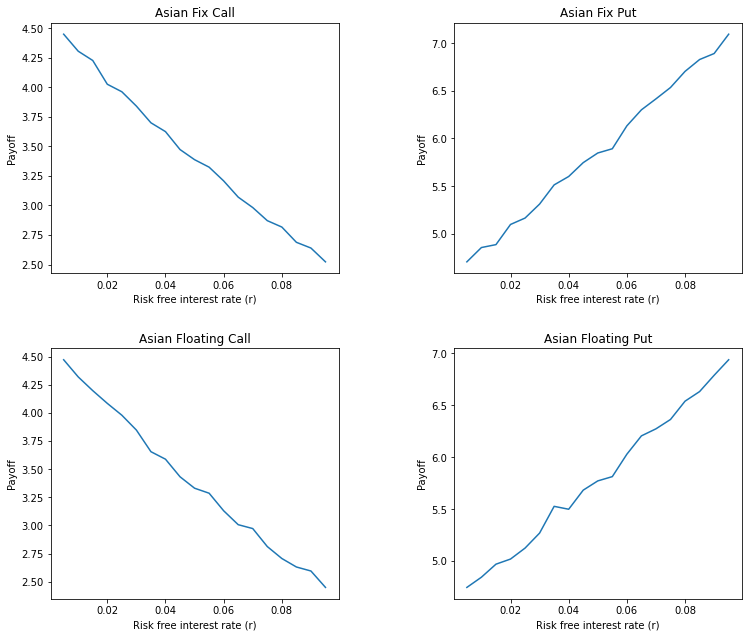

In [32]:
plt.figure(figsize=(12, 10), dpi=72)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
plt.subplot(221)
plt.plot(IR, AsianFixCall_r)
plt.title('Asian Fix Call')
plt.xlabel('Risk free interest rate (r)')
plt.ylabel('Payoff')
plt.subplot(222)
plt.plot(IR, AsianFixPut_r)
plt.title('Asian Fix Put')
plt.xlabel('Risk free interest rate (r)')
plt.ylabel('Payoff')
plt.subplot(223)
plt.plot(IR, AsianFloatCall_r)
plt.title('Asian Floating Call')
plt.xlabel('Risk free interest rate (r)')
plt.ylabel('Payoff')
plt.subplot(224)
plt.plot(IR, AsianFloatPut_r)
plt.title('Asian Floating Put')
plt.xlabel('Risk free interest rate (r)')
plt.ylabel('Payoff')

### Discussion for Different risk-free interest rate r
The higher the interest rate r is, there are two different patterns occurs.

Call option price falls

Put option price raises

r infects the result in two places:
- In random walk: we have $rdt$ as an element in the price function
- In pv: we have $pv = e^{-rT}$

From the aspect of pv, option prices should go down when r goes up.
From the view of random walk simulation, increasing interest rates can lower the prices of those assets.for Asian put options, a decrease in the underlying asset price could potentially make the puts more valuable.

---

### Geometric average vs Arithmetic average
We set the parameters back to initial values
- Today's stock price $S_0$ = 100
- Strike E = 100
- Time to expiry (T - t) = 1 year
- volatility $\sigma$ = 20%
- constant risk-free interest rate $r$ = 5%

and take 50,000 as the simulation number

In [52]:
stock_price = 100.0
r = 0.05
sigma = 0.2
dt = 1/252
n = 252
variables = (stock_price, r, sigma, dt, n)
Time = 1
Strike_price = 100

pv = np.exp(-r*Time)
simulations = 50000

In [53]:
ari_p_price, ari_average = random_walk(variables, simulations)
ari_AsianFixCall = AsianFixCall(pv, ari_average, Strike_price)
ari_AsianFixPut =AsianFixPut(pv, ari_average, Strike_price)
ari_AsianFloatCall = AsianFloatCall(pv, ari_average, ari_p_price)
ari_AsianFloatPut = AsianFloatPut(pv, ari_average, ari_p_price)

geo_p_price, geo_average = random_walk(variables, simulations, mean_method='geo_average')
geo_AsianFixCall = AsianFixCall(pv, geo_average, Strike_price)
geo_AsianFixPut =AsianFixPut(pv, geo_average, Strike_price)
geo_AsianFloatCall = AsianFloatCall(pv, geo_average, geo_p_price)
geo_AsianFloatPut = AsianFloatPut(pv, geo_average, geo_p_price)    
print('-------------|   AsianFixCall   |   AsianFixPut   |  AsianFloatCall  |  AsianFloatPut  ')
print('arithmetic : ',ari_AsianFixCall,'|', ari_AsianFixPut,'|', ari_AsianFloatCall,'|', ari_AsianFloatPut)
print('geometric:   ',geo_AsianFixCall,'|', geo_AsianFixPut,'|', geo_AsianFloatCall,'|', geo_AsianFloatPut)

-------------|   AsianFixCall   |   AsianFixPut   |  AsianFloatCall  |  AsianFloatPut  
arithmetic :  5.808896282878327 | 3.3515614545713266 | 5.88493274305764 | 3.4097633150407196
geometric:    5.609785625114493 | 3.486792114999785 | 6.053883078636599 | 3.2688610746610602


### Discussion for Geometric average vs Arithmetic average

Geometric average Asian options usually have lower premiums than arithmetic average Asian options because the geometric average reduces the impact of extreme price movements, thereby lowering the option's implied volatility.

### 3.b Different parameters on SuperShare Options

#### Try different range from L to H
let X_L + k = S = X_H - k


try k from 1 ~ 50

Text(0, 0.5, 'Payoffs')

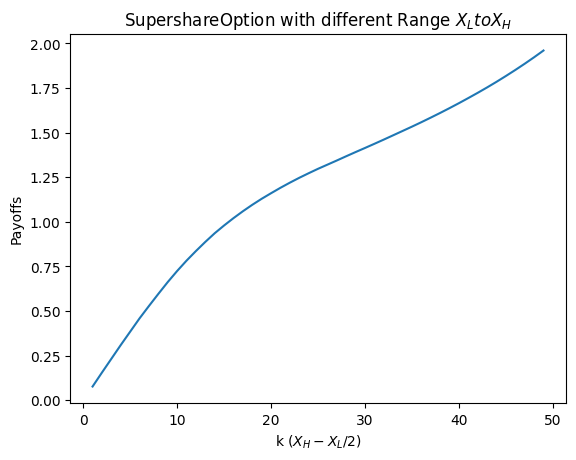

In [36]:
sso_S = 100
sso_T = 0.25
sso_r = 0.1
sso_b = 0
sso_sigma = 0.2
sso_n = 63
sso_dt = sso_T/sso_n
sso_diff_HL = []
for k in range(1,50):
    sso_X_L = sso_S - k
    sso_X_H = sso_S + k
    sso_diff_HL.append(SupershareOption(sso_pv, sso_p_price, sso_X_L, sso_X_H))

plt.plot(range(1,50), sso_diff_HL)
plt.title('SupershareOption with different Range $X_L to X_H$')
plt.xlabel('k (${X_H - X_L} / 2$)')
plt.ylabel('Payoffs')

### Discussion for different $X_H-X_L$ on supershare option
We observe that the payoff goes up as the distance $X_H-X_L$ enlarges, but the payoff curve shows a third degree polynomial curve.

First of all, the most dirrect observation will be the calculation of the payoff : $S/X_L$. when $S$ is fixed, as $X_L$ decreses, the payoff should increase. Although, as the broader band the payoff is , the lower the risk will be, so the payoff should be lower too. By summarizing these two factors, the payoff shows the third degree polynomial curve as we see above.

---

#### Try different T
we try T from 0.25 ~ 10 with step = 0.25

Text(0, 0.5, 'Payoffs')

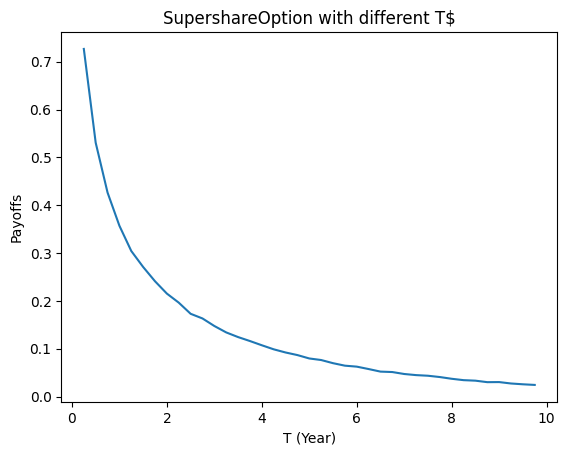

In [38]:
sso_S = 100
sso_r = 0.1
sso_b = 0
sso_X_H = 110
sso_X_L = 90
sso_sigma = 0.2
sso_diff_T = []
step = 0
for k in np.arange(0.25, 10, 0.25):
    step += 1
    sso_n = 63 * step
    sso_dt = k/sso_n

    variables = (sso_S, sso_r, sso_sigma, sso_dt, sso_n)
    simulations = 50000
    
    sso_pv = np.exp(-sso_r*k)
    sso_p_price, average = random_walk(variables, simulations)
    sso_diff_T.append(SupershareOption(sso_pv, sso_p_price, sso_X_L, sso_X_H))

plt.plot(np.arange(0.25, 10, 0.25), sso_diff_T)
plt.title('SupershareOption with different $T$')
plt.xlabel('T (Year)')
plt.ylabel('Payoffs')

### Discussion of different T for supershare option
The result of varying T on supershare option shows the same feature as Asian options. But supershare option doesn't depend on the path, so the payoff lowers faster as a log curve compared to the lineary decreasing Asian option curve.

#### Try different r
from 0.005 to 0.3 step 0.005

Text(0, 0.5, 'Payoffs')

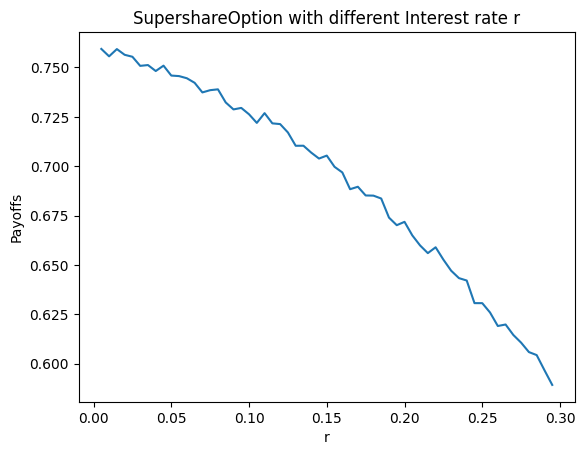

In [60]:
sso_S = 100
sso_T = 0.25
sso_b = 0
sso_sigma = 0.2
sso_n = 63
sso_dt = sso_T/sso_n
sso_diff_r = []

for rate in np.arange(0.005,0.3, 0.005):
    sso_r = rate
    variables = (sso_S, sso_r, sso_sigma, sso_dt, sso_n)
    simulations = 50000
    sso_pv = np.exp(-sso_r*sso_T)
    sso_p_price, average = random_walk(variables, simulations)
    sso_diff_r.append(SupershareOption(sso_pv, sso_p_price, sso_X_L, sso_X_H))

plt.plot(np.arange(0.005,0.3, 0.005), sso_diff_r)
plt.title('SupershareOption with different Interest rate r')
plt.xlabel('r')
plt.ylabel('Payoffs')

### Discussion of different r for supershare option
A supershare option is basically a call option, so the result is simillar to the Asian call option's result.

From the aspect of pv, option prices should go down when r goes up. From the view of random walk simulation, increasing interest rates can lower the prices of those assets.

#### Try different sigma
Try $\sigma$ from 0.05 to 0.95 with step 0.05

Text(0, 0.5, 'Payoffs')

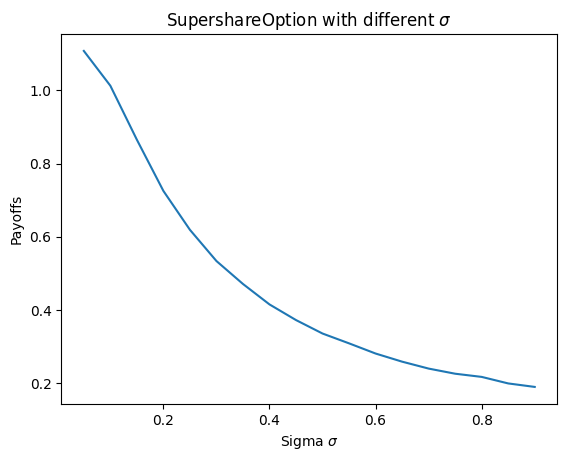

In [40]:
sso_S = 100
sso_T = 0.25
sso_b = 0
sso_r = 0.1
sso_n = 63
sso_dt = sso_T/sso_n
sso_diff_sigma = []

for sigma in np.arange(0.05,0.95, 0.05):
    sso_sigma = sigma
    variables = (sso_S, sso_r, sso_sigma, sso_dt, sso_n)
    simulations = 50000
    sso_pv = np.exp(-sso_r*sso_T)
    sso_p_price, average = random_walk(variables, simulations)
    sso_diff_sigma.append(SupershareOption(sso_pv, sso_p_price, sso_X_L, sso_X_H))

plt.plot(np.arange(0.05,0.95, 0.05), sso_diff_sigma)
plt.title('SupershareOption with different $\sigma$')
plt.xlabel('Sigma $\sigma$')
plt.ylabel('Payoffs')

### Discussion of different $\sigma$ for supershare option.
Surprising, the result of varying $\sigma$ for supershare option shows totally different result as the Asian option does. For supershare option, the larger the $\sigma$ is, the lower the payoff will be, but for Asian option, as the $\sigma$ enlarges, the payoff raises too.

The reason might because the payoff for supershare option is defined by the range of $X_H-X_L$, so a larger $\sigma$ can easily cause the prise to get out of the range and get 0 return.

### 4. Problem and discussion

#### Problems I face on the course work
1. Building the random walk function:

    At first, I tried to do a for-loop to simulate the process of a random walk, for less numbers of simulations it goes well, but when the simulations grow to the scale over 10,000, it takes too long to simulate a single task.

    To solve this problem, I looked at the lectures from Scientific Computing for Finance, and found the method of using the matirx to perform the random walk, it parallised the calculation and can do simulation much faster in large scale.

2. For supershare option:

    The supershare option equation on the webpage: http://www.derivativepricing.com/blogpage.asp?id=21 can't display correctly, and we can't check if the simulation result is close to the calculation result.

    I tried to find other resources online, and still can't find the original equation to calculate the option price, so I went to the Maughan Library to check on the book: The complete guide to option pricing formulas, and successfully found the page introducing the supershare option.

3. Deciding the simulation range:

    To decide the range for simulating different parameters isn't that straight forward. To have more promising results, I decided to let the code to the work, that is -- try as much simulating as the execution time don't take too long.

### 5. Conclusion and Reference
In this course work, I build a function to reproduce the Monte carlo scheme, and observe the results that we can't do as much on excel. When the number of simulations really upscales to more than 10,000 times, the results doesn't vary as much as the result we did on class with excel. And calculating the resuls by coding really takes no effort and the mathmetics are trully very easy. I can totally under stand the advantages of Monte carlo simulations described on the class. Changing the model doesn't require to derive a new equation, just simply change the payoff and make it a callable function simply does the trick. And doing simulations for path dependency options like Asian Fixed/ Floating options are really simple and tracing the average will be simply adding a average function on the output of the simulation.

And with the disadvantages of the Monte carlo simulations, which is we need a lot of simulations to be close to the correct answer, I don't really feel like it's a problem while we can do 50,000 simulations for four different payoffs (Asian Fixed/float put/call option) comparing on different parameters (more than 20 tries), which is more than 1,000,000 simulations in less than 5 seconds simply on a personal laptop.

1.  Paul Wilmott (2006). Paul Wilmott on Quantitative Finance 2nd Edition: 3 Volume Set. (pp. 1263-1284).Wiley.
2.  JAMES CHEN(April 21, 2022). What Is an Asian Option? How They Work Vs. Standard Options.Investopedia.https://www.investopedia.com/terms/a/asianoption.asp
3.  Paul Wilmott (2006). Paul Wilmott on Quantitative Finance 2nd Edition: 3 Volume Set. (pp. 427-444).Wiley.
4.  Haug, E. G. (2007). The complete guide to option pricing formulas (Second edition.). (pp. 176) McGraw-Hill. 